# Identify AR Events Gridded

In [1]:
%matplotlib ipympl

In [106]:
import ARUtils
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature 

Load data from 1980 - 1989

In [3]:
ds_full = xr.open_dataset('b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.1980010100-1989123100.nc')

Select a set of grid cells that cover Bodega Bay, CA (38.3332° N, 123.0481° W)

In [59]:
lat = 38.
lon = -123.125 + 360 
AR_THRESHOLD = 250.
cell_buffer = 10

# the nearest index for the lat/lon provided above
ilon = list(ds_full.lon.values).index(ds_full.sel(lon=lon, method='nearest').lon)
ilat = list(ds_full.lat.values).index(ds_full.sel(lat=lat, method='nearest').lat)

# subset these data to include cells above and below this lat/lon
ds = ds_full.isel(lat=range(ilat-cell_buffer, ilat+cell_buffer),
                  lon=range(ilon-cell_buffer, ilon+cell_buffer)).IVT
ds = ds.to_dataset()

Plot the IVT data for these cells at `time=0` to visualize our domain.

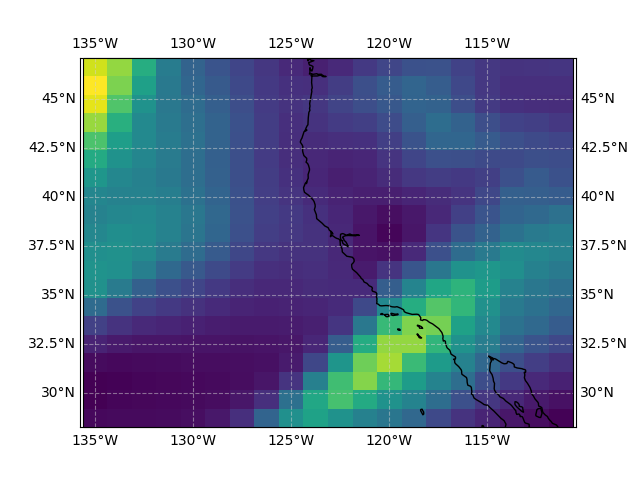

In [107]:
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
ax = plt.axes(projection=ccrs.PlateCarree())

#add coastlines
ax.add_feature(cfeature.COASTLINE)

#add lat lon grids
gl = ax.gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--')
gl.xlabels_bottom = False
gl.ylabels_right = False

ds.isel(time=0).IVT.plot(label='',
                         add_labels=False,
                         add_colorbar=False,
                         xticks=None,
                         yticks=None)
plt.show()

In [108]:
ds['AR_INDEX'] = xr.apply_ufunc(
    ARUtils.identify_ar_events,  
    ds.IVT,  
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True
)

In [109]:
ds['AR_DURATION'] = xr.apply_ufunc(
    ARUtils.compute_ar_durations,  
    ds.AR_INDEX,  
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True
)

In [110]:
ds['AR_CATEGORY'] = xr.apply_ufunc(
    ARUtils.compute_ar_category,  
    ds.AR_INDEX,
    ds.AR_DURATION,
    ds.IVT,
    input_core_dims=[["time"],["time"],["time"]],
    output_core_dims=[["time"]],
    vectorize=True
)

## Plot Computed AR Category

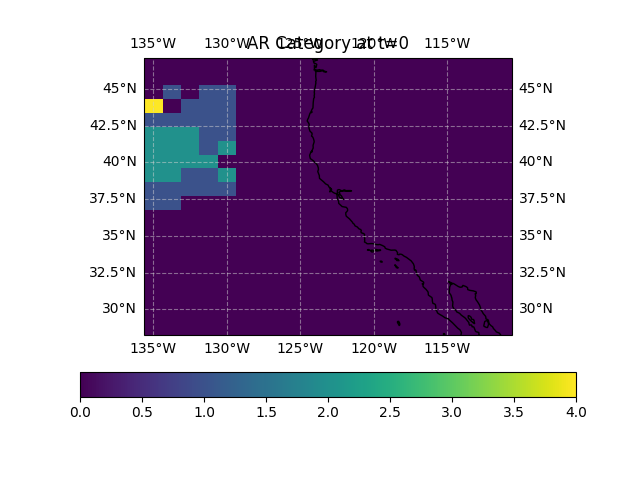

In [122]:
fig, ax = plt.subplots()
ax.axis('off')

ax = plt.axes(projection=ccrs.PlateCarree())

#add coastlines
ax.add_feature(cfeature.COASTLINE)

#add lat lon grids
gl = ax.gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--')
gl.xlabels_bottom = False
gl.ylabels_right = False

ds.isel(time=0).AR_CATEGORY.plot(label='',
                                 add_labels=False,
                                 add_colorbar=True,
                                 xticks=None,
                                 yticks=None,
                                 cbar_kwargs={"location": "bottom", "pad":0.1})

plt.title('AR Category at t=0')
plt.show()

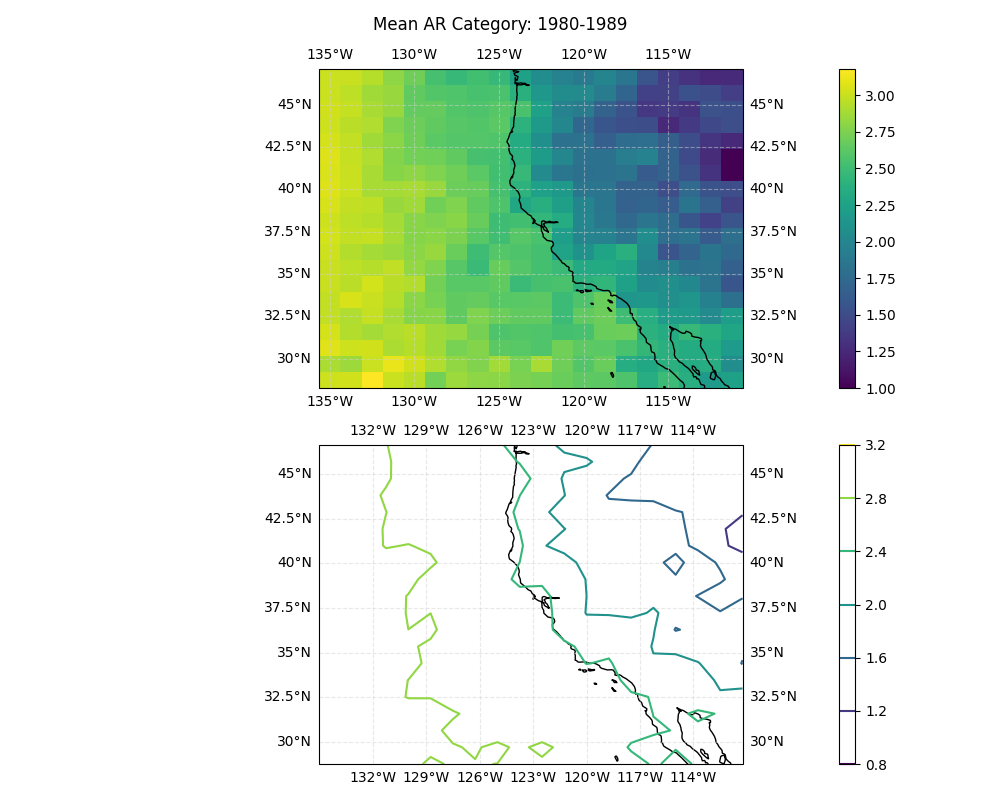

In [161]:
fig, ax = plt.subplots(nrows=2, ncols=1,
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,8))
#ax[0].axis('off')
#ax[1].axis('off')

ax[0].coastlines();
ax[1].coastlines();

#add lat lon grids
ax[0].gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--');
ax[1].gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--');


ds.where(ds.AR_CATEGORY > 0).AR_CATEGORY.mean(dim='time').plot(label='',
                                                               add_labels=False,
                                                               add_colorbar=True,
                                                               cbar_kwargs={"location": "right", "pad":0.1},
                                                               ax=ax[0])

ds.where(ds.AR_CATEGORY > 0).AR_CATEGORY.mean(dim='time').plot.contour(
                                                               add_labels=False,
                                                               add_colorbar=True,
                                                               cbar_kwargs={"location": "right", "pad":0.1},
                                                               ax=ax[1])

fig.suptitle('Mean AR Category: 1980-1989')
plt.tight_layout()
plt.show()